# Importing libraries

In [18]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import pandas as pd
from nltk.cluster import KMeansClusterer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import WordPunctTokenizer, sent_tokenize
from nltk.corpus import stopwords
import gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import networkx as nx
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/toyesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/toyesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Importing dataset

In [2]:
df_master = pd.read_csv('/Users/toyesh/Documents/College Work/Year 2022-23/Thesis/comments.csv', sep=';')

In [16]:
df = df_master.head(10000)

# Data pre-processing

In [19]:
tokenizer = WordPunctTokenizer()
stopwords = set(stopwords.words('dutch'))

preprocessed_comments = []

for comment in df['text']:
    tokens = tokenizer.tokenize(comment.lower())
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords]
    preprocessed_comments.append(' '.join(tokens))

# Objective vs. subjective classification: post level

In [20]:
vectorizer = TfidfVectorizer()
comment_vectors = vectorizer.fit_transform(preprocessed_comments)

k = 2  # number of clusters (objective and subjective)
clusterer = KMeansClusterer(k, distance=nltk.cluster.util.cosine_distance, repeats=25)
cluster_labels = clusterer.cluster(comment_vectors.toarray(), assign_clusters=True)

df['comment_label'] = [1 if label == 0 else 0 for label in cluster_labels]

# Objective vs. subjective classification: sentence level

In [21]:
df['sentences'] = df['text'].apply(nltk.sent_tokenize)
sentences = [sentence for sentences in df['sentences'] for sentence in sentences]
sentence_vectors = vectorizer.fit_transform(sentences)
sentence_clusterer = KMeans(n_clusters=k)
sentence_cluster_labels = sentence_clusterer.fit_predict(sentence_vectors)
df['sentence_cluster_labels'] = df['sentences'].apply(lambda sentences: [sentence_cluster_labels[i] for i in range(len(sentences))])
df['sentence_comment_label'] = df['sentence_cluster_labels'].apply(lambda labels: 1 if sum(labels) > len(labels) / 2 else 0)

# Post level vs sentence level classification comparison

In [22]:
original_labels = df['comment_label']
similarity = (df['sentence_comment_label'] == original_labels).mean()
print(f"Similarity between original and new implementations: {similarity}")

Similarity between original and new implementations: 0.5836


# Thread structure analysis

In [23]:
threads = {}

for index, row in df.iterrows():
    comment_id = row['comment_id']
    parent_id = row['comment_parent_id']
    comment_type = cluster_labels[index]

    if pd.isnull(parent_id) or parent_id not in threads:
        threads[comment_id] = {'comment': preprocessed_comments[index], 'replies': [], 'type': comment_type, 'subjective_count': 0, 'objective_count': 0}
    else:
        parent_thread = threads[parent_id]
        parent_thread['replies'].append({'comment': preprocessed_comments[index], 'comment_id': comment_id, 'type': comment_type})

for thread_id, thread in threads.items():
    thread['subjective_count'] = sum(reply['type'] == 1 for reply in thread['replies'])
    thread['objective_count'] = sum(reply['type'] == 0 for reply in thread['replies'])

# Analysing patterns in thread structures

In [24]:
patterns = []

for thread_id, thread in threads.items():
    parent_type = thread['type']
    reply_types = [reply['type'] for reply in thread['replies']]

    if reply_types:
        if all(reply_type == 1 for reply_type in reply_types):
            patterns.append({'pattern': 'Objective comment replied on by only subjective posts', 'comment': thread['comment'], 'replies': [reply['comment'] for reply in thread['replies']]})

        if all(reply_type == 0 for reply_type in reply_types):
            patterns.append({'pattern': 'Subjective comment with only objective replies', 'comment': thread['comment'], 'replies': [reply['comment'] for reply in thread['replies']]})

        if any(reply_type != parent_type for reply_type in reply_types):
            patterns.append({'pattern': 'Subjective comment with both objective and subjective replies', 'comment': thread['comment'], 'replies': [reply['comment'] for reply in thread['replies']]})

# Hierarchy visualisation

In [ ]:
graph = nx.DiGraph()

for thread_id, thread in threads.items():
    graph.add_node(thread_id, comment=thread['comment'], type=thread['type'])

    for reply in thread['replies']:
        graph.add_node(reply['comment_id'], comment=reply['comment'], type=reply['type'])

for thread_id, thread in threads.items():
    for reply in thread['replies']:
        graph.add_edge(thread_id, reply['comment_id'])

plt.figure(figsize=(100, 50))
pos = nx.spring_layout(graph)

objective_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 0]
subjective_nodes = [node for node, data in graph.nodes(data=True) if data['type'] == 1]

nx.draw_networkx_nodes(graph, pos, nodelist=objective_nodes, node_size=300, node_color='blue')
nx.draw_networkx_nodes(graph, pos, nodelist=subjective_nodes, node_size=300, node_color='red')
nx.draw_networkx_edges(graph, pos, arrows=True)

node_labels = {node: data['comment'] for node, data in graph.nodes(data=True)}
nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=8)

plt.title("Comment Thread Visualization")
plt.axis('off')
# plt.show()


# Topic Modeling

In [26]:
num_topics = 5
dictionary = gensim.corpora.Dictionary([comment.split() for comment in preprocessed_comments])
corpus = [dictionary.doc2bow(comment.split()) for comment in preprocessed_comments]
lda = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=0)


# Evaluating topic modelling

In [27]:
coherence_model = CoherenceModel(model=lda, texts=[comment.split() for comment in preprocessed_comments], dictionary=dictionary, coherence='u_mass')
umass_coherence_score = coherence_model.get_coherence()

print(f"UMass Coherence Score: {umass_coherence_score}")

UMass Coherence Score: -2.728337989040465


# Temporal analysis

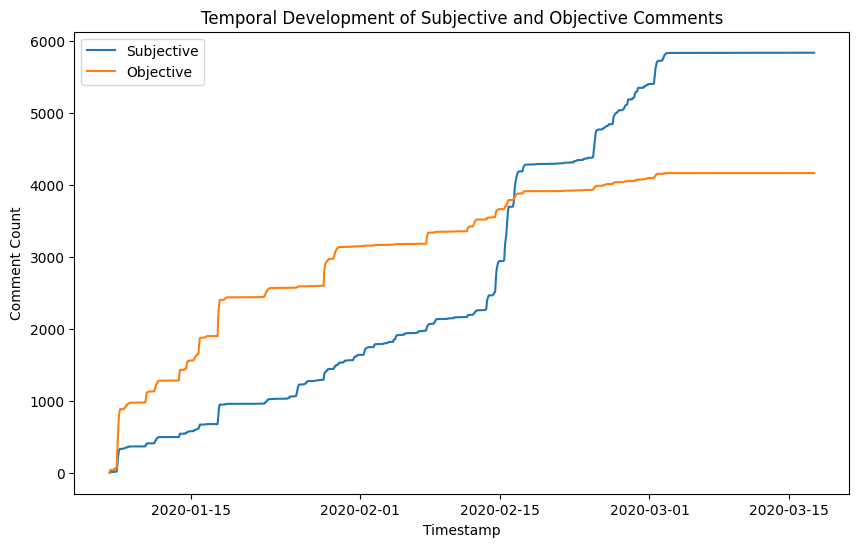

In [28]:
df['timestamp'] = df['timestamp'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.sort_values('timestamp')

subjective_counts = []
objective_counts = []

for index, row in df.iterrows():
    timestamp = row['timestamp']
    comment_type = row['comment_label']

    subjective_count = sum(df.loc[df['timestamp'] <= timestamp, 'comment_label'] == 1)
    objective_count = sum(df.loc[df['timestamp'] <= timestamp, 'comment_label'] == 0)

    subjective_counts.append(subjective_count)
    objective_counts.append(objective_count)

df['subjective_count'] = subjective_counts
df['objective_count'] = objective_counts

plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['subjective_count'], label='Subjective')
plt.plot(df['timestamp'], df['objective_count'], label='Objective')
plt.xlabel('Timestamp')
plt.ylabel('Comment Count')
plt.title('Temporal Development of Subjective and Objective Comments')
plt.legend()
plt.show()

# Summary

In [29]:
num_subjective = sum(cluster_labels)
num_objective = len(cluster_labels) - num_subjective

summary = "Discussion Summary:\n\n"
summary += f"Number of Subjective Opinions (Comments): {num_subjective}\n"
summary += f"Number of Objective Opinions (Comments): {num_objective}\n\n"

summary += "Thread Analysis:\n"
for thread_id, thread in threads.items():
    if thread['replies']:
        summary += f"Parent Comment: {thread['comment']} (Type: {'Subjective' if thread['type'] == 1 else 'Objective'})\n"
        summary += f"\tSubjective Replies: {thread['subjective_count']}\n"
        summary += f"\tObjective Replies: {thread['objective_count']}\n"

        for reply in thread['replies']:
            summary += f"\tReply Comment: {reply['comment']} (Type: {'Subjective' if reply['type'] == 1 else 'Objective'})\n"

        summary += "\n"

summary += "Pattern Analysis:\n"
for pattern in patterns:
    summary += f"- Pattern: {pattern['pattern']}\n"
    summary += f"  Comment: {pattern['comment']}\n"
    summary += f"  Replies:\n"
    for reply in pattern['replies']:
        summary += f"  - {reply}\n"
    summary += "\n"

summary += "\nTopic Modeling:\n"
for i, topic in enumerate(lda.get_topics()):
    summary += f"Topic {i+1} - Top Words: {', '.join([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[:-6:-1]])}\n"

# Displaying results

In [32]:
# print(summary)

In [31]:
file_path = "/Users/toyesh/Documents/College Work/Year 2022-23/Thesis/summary.txt"

with open(file_path, "w") as file:
    file.write(summary)